# Recipe 1M + Spark

Outline
- Downloads
- Imports
- Loading Data

# Downloads

In [1]:
# # Java
# !apt-get update
# !apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [58]:
# Pyhon libary installs
# NOTE: Might need apache spark downloads, check later
# !pip install pandas

# !pip install pyspark
# !pip install spark-nlp==3.0.0
# !python -m pip install -U matplotlib #might not need this
# !pip install bokeh

# Imports

In [3]:
# Expands the width of the notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))


In [4]:
# TODO: Check which ones get used
import random
import json

import pandas as pd
import matplotlib.pyplot as plt

import pyspark
from pyspark.ml import Pipeline
from pyspark.ml.feature import SQLTransformer
from pyspark.ml.feature import Normalizer
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import udf, col
from pyspark.ml.linalg import Vector, Vectors, VectorUDT
# from org.apache.spark.ml.linal import Vector, Vectors # Typo in John Snow Labs

from pyspark.sql.functions import UserDefinedFunction
from pyspark.sql.types import StringType, DoubleType
from pyspark.ml.clustering import LDA

from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator


import pyspark.sql.functions as F
from pyspark.sql.functions import explode

import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *              
from sparknlp.pretrained import PretrainedPipeline

In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

In [6]:
import os
os.environ['JAVA_HOME'] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [7]:
# Adjust GPU and memory for individual use
import sparknlp
# spark = sparknlp.start()
# for GPU training >> spark = sparknlp.start(gpu=True)
spark = sparknlp.start(gpu=True, memory="32G")

In [8]:
# Difference between spark session and spark context, can access spark context through spark session
# https://medium.com/@achilleus/spark-session-10d0d66d1d24
type(spark)

pyspark.sql.session.SparkSession

In [9]:
sparknlp.version()
spark.version

'3.1.1'

# Load and Format Data 

TODO: Facts about the data
- sourced
- layer1.json
- etc

In [159]:
# file_path = '/content/drive/MyDrive/layer1.json'
file_path = 'layer1.json'

In [160]:
# Read in the file to a pyspark dataframe type
data_df = spark.read.json(file_path)

In [161]:
# Drop uncessary columns
cols_to_drop1 = ("_corrupt_record", "url", "partition", "instructions") 
df_ingredients = data_df.drop(*cols_to_drop1)

# Drop null values
df_ingredients = df_ingredients.dropna()

In [162]:
# View the data schema
df_ingredients.printSchema()

root
 |-- id: string (nullable = true)
 |-- ingredients: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- text: string (nullable = true)
 |-- title: string (nullable = true)



In [163]:
df_ingredients.show()

+----------+--------------------+--------------------+
|        id|         ingredients|               title|
+----------+--------------------+--------------------+
|000018c8a5|[{6 ounces penne}...|Worlds Best Mac a...|
|000033e39b|[{1 c. elbow maca...|Dilly Macaroni Sa...|
|000035f7ed|[{8 tomatoes, qua...|            Gazpacho|
|00003a70b1|[{2 12 cups milk}...|Crunchy Onion Pot...|
|00004320bb|[{1 (3 ounce) pac...|Cool 'n Easy Crea...|
|0000631d90|[{12 cup shredded...|Easy Tropical Bee...|
|000075604a|[{2 Chicken thigh...|Kombu Tea Grilled...|
|00007bfd16|[{6 -8 cups fresh...|Strawberry Rhubar...|
|000095fc1d|[{8 ounces, weigh...|     Yogurt Parfaits|
|0000973574|[{2 cups flour}, ...|  Zucchini Nut Bread|
|0000a4bcf6|[{1/2 cup green o...|Salmon & Salad a ...|
|0000b1e2b5|[{1 teaspoon fenn...|Fennel-Rubbed Por...|
|0000c79afb|[{1 (750 ml) bott...|        Pink Sangria|
|0000ed95f8|[{14 cup butter},...|      Pineapple Loaf|
|00010379bf|[{200 grams Cake ...|Brown Sugar 'Kari...|
|000106ec3

In [164]:
# Size of dataframe
df_ingredients.count()

1029720

In [165]:
# For testing purposes: sample the size
df_ingredients = spark.createDataFrame(df_ingredients.head(100))
df_ingredients.count()

100

In [157]:
# Convert the ingredients from an aray of strings to one string
# Using UDF was definitely new to me
# For more information on why to use udf instead of map 
# https://medium.com/@fqaiser94/udfs-vs-map-vs-custom-spark-native-functions-91ab2c154b44
# https://stackoverflow.com/questions/29109916/updating-a-dataframe-column-in-spark

name = 'ingredients' #taret_column name
# Returns the list joined together with periods as seperators
def parse_ingredients(ingredients):
    return '. '.join([data['text'] for data in ingredients])

udf1 = UserDefinedFunction(parse_ingredients, StringType())

df_ingredients = df_ingredients.select(*[udf1(column).alias(name) if column == name else column for column in df_ingredients.columns])

In [158]:
# As you can see below, the ingredients are strings now
df_ingredients.show()

PythonException: 
  An exception was thrown from the Python worker. Please see the stack trace below.
Traceback (most recent call last):
  File "/home/egong/miniconda3/envs/767_py3/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 604, in main
    process()
  File "/home/egong/miniconda3/envs/767_py3/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 596, in process
    serializer.dump_stream(out_iter, outfile)
  File "/home/egong/miniconda3/envs/767_py3/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 211, in dump_stream
    self.serializer.dump_stream(self._batched(iterator), stream)
  File "/home/egong/miniconda3/envs/767_py3/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 132, in dump_stream
    for obj in iterator:
  File "/home/egong/miniconda3/envs/767_py3/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 200, in _batched
    for item in iterator:
  File "/home/egong/miniconda3/envs/767_py3/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 450, in mapper
    result = tuple(f(*[a[o] for o in arg_offsets]) for (arg_offsets, f) in udfs)
  File "/home/egong/miniconda3/envs/767_py3/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 450, in <genexpr>
    result = tuple(f(*[a[o] for o in arg_offsets]) for (arg_offsets, f) in udfs)
  File "/home/egong/miniconda3/envs/767_py3/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 85, in <lambda>
    return lambda *a: f(*a)
  File "/home/egong/miniconda3/envs/767_py3/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/util.py", line 73, in wrapper
    return f(*args, **kwargs)
  File "/home/egong/miniconda3/envs/767_py3/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 77, in <lambda>
    return lambda *a: g(f(*a))
  File "<ipython-input-157-f30890fab8e1>", line 10, in parse_ingredients
  File "<ipython-input-157-f30890fab8e1>", line 10, in <listcomp>
TypeError: string indices must be integers


# Introduce Pyspark NLP Pipeline

In [19]:
# Document Assembler: Converts our raw data into a format for the Pyspark NLP to use for other parts of the pipeline, 
# specefically in the "Document" type
documentAssembler = DocumentAssembler() \
    .setInputCol("ingredients") \
    .setOutputCol("document") \
    .setCleanupMode("shrink")

In [20]:
# Typo in the documentation: 
# Documentation: BertSentenceembeddings (missing uppercase in the E)
# Correction: BertSentenceEmbeddings
sentence_embeddings = BertSentenceEmbeddings.pretrained() \
    .setInputCols("document") \
    .setOutputCol("sentence_embeddings") \
    .setLazyAnnotator(False)

sent_small_bert_L2_768 download started this may take some time.
Approximate size to download 139.6 MB
[OK!]


In [21]:
# The documentation states after SentenceEmbeddings that you will need to convert 
# these embeddings into Vectors or what's known as Feature column so it can be used in Spark ML
# Correction: The documentation states its in python, however the code is not python and a mixture between Scala and other typos
# Instead, you can use the embeddings finisher to help format the vectors

embeddings_finisher = EmbeddingsFinisher() \
            .setInputCols(["sentence_embeddings"]) \
            .setOutputCols("sentence_embeddings_vectors") \
            .setOutputAsVector(True)

In [22]:
# Now we add all of these elements to the pipeline
pipeline = Pipeline(
    stages=[
        documentAssembler, 
        sentence_embeddings,
        embeddings_finisher
 ])

In [23]:
# fit the pipeline on ingredients data
pipelineModel = pipeline.fit(df_ingredients)

In [24]:
# transform ingredients data into BERT vectors
transformed_df = pipelineModel.transform(df_ingredients)

In [25]:
transformed_df.printSchema()

root
 |-- id: string (nullable = true)
 |-- ingredients: string (nullable = true)
 |-- title: string (nullable = true)
 |-- document: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- annotatorType: string (nullable = true)
 |    |    |-- begin: integer (nullable = false)
 |    |    |-- end: integer (nullable = false)
 |    |    |-- result: string (nullable = true)
 |    |    |-- metadata: map (nullable = true)
 |    |    |    |-- key: string
 |    |    |    |-- value: string (valueContainsNull = true)
 |    |    |-- embeddings: array (nullable = true)
 |    |    |    |-- element: float (containsNull = false)
 |-- sentence_embeddings: array (nullable = true)
 |    |-- element: struct (containsNull = false)
 |    |    |-- annotatorType: string (nullable = true)
 |    |    |-- begin: integer (nullable = false)
 |    |    |-- end: integer (nullable = false)
 |    |    |-- result: string (nullable = true)
 |    |    |-- metadata: map (nullable = true)
 

In [26]:
transformed_df.show()

+----------+--------------------+--------------------+--------------------+--------------------+---------------------------+
|        id|         ingredients|               title|            document| sentence_embeddings|sentence_embeddings_vectors|
+----------+--------------------+--------------------+--------------------+--------------------+---------------------------+
|000018c8a5|6 ounces penne. 2...|Worlds Best Mac a...|[{document, 0, 51...|[{sentence_embedd...|       [[0.2496253103017...|
|000033e39b|1 c. elbow macaro...|Dilly Macaroni Sa...|[{document, 0, 24...|[{sentence_embedd...|       [[0.3729802668094...|
|000035f7ed|8 tomatoes, quart...|            Gazpacho|[{document, 0, 30...|[{sentence_embedd...|       [[0.2992067039012...|
|00003a70b1|2 12 cups milk. 1...|Crunchy Onion Pot...|[{document, 0, 17...|[{sentence_embedd...|       [[0.3870077133178...|
|00004320bb|1 (3 ounce) packa...|Cool 'n Easy Crea...|[{document, 0, 15...|[{sentence_embedd...|       [[0.4652682244777...|


In [27]:
# Demonstrate the type here is a list when a Dense vector is desired
type(transformed_df.collect()[0]['sentence_embeddings_vectors'])

list

In [28]:
# The data for the sentence_embeddings_vectors is in a list of DenseVectors rather than just DenseVectors
# I have no idea why, have to figure that out
# Correction: I use a UDF to convert the list to the DenseVector 

list_to_vector_udf = udf(lambda l: l[0], VectorUDT())
transformed_df = transformed_df.select(transformed_df['id'], transformed_df['title'], transformed_df['ingredients'], list_to_vector_udf(transformed_df['sentence_embeddings_vectors']).alias("features"))

In [29]:
# Here you can see sentence_embeddings_vectors has been reduced down to DenseVectors
transformed_df.show()

+----------+--------------------+--------------------+--------------------+
|        id|               title|         ingredients|            features|
+----------+--------------------+--------------------+--------------------+
|000018c8a5|Worlds Best Mac a...|6 ounces penne. 2...|[0.24962531030178...|
|000033e39b|Dilly Macaroni Sa...|1 c. elbow macaro...|[0.37298026680946...|
|000035f7ed|            Gazpacho|8 tomatoes, quart...|[0.29920670390129...|
|00003a70b1|Crunchy Onion Pot...|2 12 cups milk. 1...|[0.38700771331787...|
|00004320bb|Cool 'n Easy Crea...|1 (3 ounce) packa...|[0.46526822447776...|
|0000631d90|Easy Tropical Bee...|12 cup shredded c...|[0.47590991854667...|
|000075604a|Kombu Tea Grilled...|2 Chicken thighs....|[0.27038058638572...|
|00007bfd16|Strawberry Rhubar...|6 -8 cups fresh r...|[0.37211418151855...|
|000095fc1d|     Yogurt Parfaits|8 ounces, weight ...|[0.45405924320220...|
|0000973574|  Zucchini Nut Bread|2 cups flour. 1 t...|[0.42598998546600...|
|0000a4bcf6|

In [32]:
# The correct type to go into Spark ML
type(transformed_df.collect()[0]['features'])

pyspark.ml.linalg.DenseVector

# Spark ML

## LDA

In [33]:
# num_topics = 3
# lda = LDA(k=num_topics, maxIter=1)
# lda_model = lda.fit(transformed_df)

In [34]:
# topics = lda_model.describeTopics(3)
# print("The topics described by their top-weighted terms:")
# topics.show(truncate=False)

In [35]:
# # Shows the result
# transformed = lda_model.transform(transformed_df)
# transformed.show(truncate=False)

## K-Means

In [37]:
silhouette_score=[]
evaluator = ClusteringEvaluator()

for i in range(2,10):
    kmeans = KMeans().setK(i).setSeed(1)
    kmeans_model = kmeans.fit(transformed_df)
    predictions = kmeans_model.transform(transformed_df)
    silhouette = evaluator.evaluate(predictions)
    silhouette_score.append(silhouette)
    
    print("Silhouette Score:",silhouette)
# https://towardsdatascience.com/k-means-clustering-using-pyspark-on-big-data-6214beacdc8b

Silhouette Score: 0.14668229340509278
Silhouette Score: 0.11190371639296828
Silhouette Score: 0.1285438386571317
Silhouette Score: 0.12905865785682435
Silhouette Score: 0.09172660328605911
Silhouette Score: 0.10026406514072488
Silhouette Score: 0.09635323472794038
Silhouette Score: 0.04150263483081923


Text(0, 0.5, 'cost')

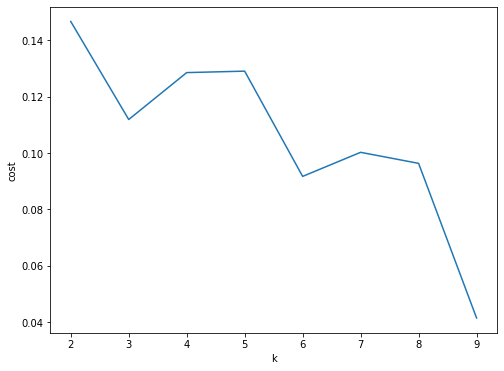

In [38]:
# Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,10),silhouette_score)
ax.set_xlabel('k')
ax.set_ylabel('cost')

In [39]:
kmeans = KMeans().setK(5).setSeed(1)
kmeans_model = kmeans.fit(transformed_df)

# Make predictions
transformed = kmeans_model.transform(transformed_df).select('id', 'prediction')

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

# Shows the result.
# centers = kmeans_model.clusterCenters()
# print("Cluster Centers: ")
# for center in centers:
#     print(center)

In [40]:
# https://rsandstroem.github.io/sparkkmeans.html
rows = transformed.collect()
print(rows[:3])

[Row(id='000018c8a5', prediction=3), Row(id='000033e39b', prediction=0), Row(id='000035f7ed', prediction=0)]


In [41]:
df_pred = spark.createDataFrame(rows)
df_pred.show()

+----------+----------+
|        id|prediction|
+----------+----------+
|000018c8a5|         3|
|000033e39b|         0|
|000035f7ed|         0|
|00003a70b1|         1|
|00004320bb|         3|
|0000631d90|         1|
|000075604a|         0|
|00007bfd16|         3|
|000095fc1d|         3|
|0000973574|         1|
|0000a4bcf6|         1|
|0000b1e2b5|         1|
|0000c79afb|         2|
|0000ed95f8|         1|
|00010379bf|         0|
|000106ec3c|         0|
|00010c7867|         1|
|00010d44c7|         1|
|00011e0b2c|         0|
|00011fc1f9|         1|
+----------+----------+
only showing top 20 rows



In [42]:
test_transformed = kmeans_model.transform(transformed_df).select('id', 'title', 'ingredients', 'prediction')

In [43]:
test_rows = test_transformed.collect()
print(rows[:3])

[Row(id='000018c8a5', prediction=3), Row(id='000033e39b', prediction=0), Row(id='000035f7ed', prediction=0)]


In [44]:
test_df_pred = spark.createDataFrame(test_rows)
test_df_pred.show()

+----------+--------------------+--------------------+----------+
|        id|               title|         ingredients|prediction|
+----------+--------------------+--------------------+----------+
|000018c8a5|Worlds Best Mac a...|6 ounces penne. 2...|         3|
|000033e39b|Dilly Macaroni Sa...|1 c. elbow macaro...|         0|
|000035f7ed|            Gazpacho|8 tomatoes, quart...|         0|
|00003a70b1|Crunchy Onion Pot...|2 12 cups milk. 1...|         1|
|00004320bb|Cool 'n Easy Crea...|1 (3 ounce) packa...|         3|
|0000631d90|Easy Tropical Bee...|12 cup shredded c...|         1|
|000075604a|Kombu Tea Grilled...|2 Chicken thighs....|         0|
|00007bfd16|Strawberry Rhubar...|6 -8 cups fresh r...|         3|
|000095fc1d|     Yogurt Parfaits|8 ounces, weight ...|         3|
|0000973574|  Zucchini Nut Bread|2 cups flour. 1 t...|         1|
|0000a4bcf6|Salmon & Salad a ...|1/2 cup green oni...|         1|
|0000b1e2b5|Fennel-Rubbed Por...|1 teaspoon fennel...|         1|
|0000c79af

In [45]:
df_pred = df_pred.join(transformed_df, 'id')
df_pred.show()

+----------+----------+--------------------+--------------------+--------------------+
|        id|prediction|               title|         ingredients|            features|
+----------+----------+--------------------+--------------------+--------------------+
|00011fc1f9|         1|Lentils Vegetable...|1 cup lentils. 12...|[0.36389616131782...|
|00004320bb|         3|Cool 'n Easy Crea...|1 (3 ounce) packa...|[0.46526822447776...|
|000033e39b|         0|Dilly Macaroni Sa...|1 c. elbow macaro...|[0.37298026680946...|
|00050db874|         1| Peanut Butter Bread|34 cup peanut but...|[0.25108271837234...|
|000368efd3|         0|Cheesy Herbed Egg...|2 eggs, scrambled...|[0.32029792666435...|
|00033f624d|         0|Amy's Cheesey , B...|1/4 cup butter. 1...|[0.49439576268196...|
|00010379bf|         0|Brown Sugar 'Kari...|200 grams Cake fl...|[0.28160929679870...|
|0002491373|         1|    Tex-Mex Caponata|nonstick cooking ...|[0.45599916577339...|
|00052b48d3|         0|         Revoltillos

In [46]:
pddf_pred = df_pred.toPandas().set_index('id')
pddf_pred.head()

,prediction,title,ingredients,features
id,,,,
00011fc1f9,1,Lentils Vegetable Soup,1 cup lentils. 12 onion (finely chopped). 1 to...,"[0.3638961613178253, -0.37362033128738403, -0...."
00004320bb,3,Cool 'n Easy Creamy Watermelon Pie,1 (3 ounce) package watermelon gelatin. 14 cup...,"[0.46526822447776794, -0.23836040496826172, 0...."
000033e39b,0,Dilly Macaroni Salad Recipe,1 c. elbow macaroni. 1 c. cubed American chees...,"[0.3729802668094635, -0.4489460587501526, -0.2..."
00050db874,1,Peanut Butter Bread,34 cup peanut butter. 12 cup sugar. 1 teaspoon...,"[0.25108271837234497, -0.4261821210384369, -0...."
000368efd3,0,Cheesy Herbed Egg Sandwich,"2 eggs, scrambled. 2 Tbsp. PHILADELPHIA Chive ...","[0.3202979266643524, -0.5811638236045837, -0.1..."


In [47]:
print(type(pddf_pred['features'][0]))
denseVector = pddf_pred['features'][0]

<class 'pyspark.ml.linalg.DenseVector'>


In [50]:
# mlib is incompatible with ml
# https://stackoverflow.com/questions/41074182/cannot-convert-type-class-pyspark-ml-linalg-sparsevector-into-vector
#  ml library is designed for DataFrame-Objects and the mllib library is for RDD-objects
# So the example from https://spark.apache.org/docs/latest/mllib-dimensionality-reduction#principal-component-analysis-pca uses mlibml pc
# Instead you must use the following for reference: https://spark.apache.org/docs/1.5.1/ml-features.html#pca
from pyspark.ml.feature import PCA
from pyspark.mllib.linalg import Vectors


pca = PCA(k=2, inputCol="features", outputCol="pcaFeatures")
pca_model = pca.fit(df_pred)
result = pca_model.transform(df_pred).select("id", "title", "ingredients", "pcaFeatures")
result.show()

+----------+--------------------+--------------------+--------------------+
|        id|               title|         ingredients|         pcaFeatures|
+----------+--------------------+--------------------+--------------------+
|00011fc1f9|Lentils Vegetable...|1 cup lentils. 12...|[-1.5658635956364...|
|00004320bb|Cool 'n Easy Crea...|1 (3 ounce) packa...|[-1.0292415508838...|
|000033e39b|Dilly Macaroni Sa...|1 c. elbow macaro...|[-0.6938908218629...|
|00050db874| Peanut Butter Bread|34 cup peanut but...|[-3.5653463062817...|
|000368efd3|Cheesy Herbed Egg...|2 eggs, scrambled...|[-0.6741251393958...|
|00033f624d|Amy's Cheesey , B...|1/4 cup butter. 1...|[-0.9005175688029...|
|00010379bf|Brown Sugar 'Kari...|200 grams Cake fl...|[-1.3607978530125...|
|0002491373|    Tex-Mex Caponata|nonstick cooking ...|[-0.8811579354276...|
|00052b48d3|         Revoltillos|3 cups cooked bro...|[-0.0547448751647...|
|00010c7867|Grandmommy's Mexi...|1 12 lbs ground b...|[-1.5309009627948...|
|00029df38f|

In [60]:

result = (result.withColumn("dim", vector_to_array("pcaFeatures"))).select(["id"] + ["title"] + ["ingredients"] + [col("dim")[i] for i in range(2)])

AnalysisException: cannot resolve '`pcaFeatures`' given input columns: [dim[0], dim[1], id, ingredients, title];
'Project [id#1097, title#129, ingredients#122, dim[0]#1233, dim[1]#1234, UDF('pcaFeatures) AS dim#1263]
+- Project [id#1097, title#129, ingredients#122, dim#1227[0] AS dim[0]#1233, dim#1227[1] AS dim[1]#1234]
   +- Project [id#1097, title#129, ingredients#122, pcaFeatures#1190, UDF(pcaFeatures#1190) AS dim#1227]
      +- Project [id#1097, title#129, ingredients#122, pcaFeatures#1190]
         +- Project [id#1097, prediction#1098L, title#129, ingredients#122, features#203, UDF(features#203) AS pcaFeatures#1190]
            +- Project [id#1097, prediction#1098L, title#129, ingredients#122, features#203]
               +- Join Inner, (id#1097 = id#115)
                  :- LogicalRDD [id#1097, prediction#1098L], false
                  +- Project [id#115, title#129, ingredients#122, <lambda>(sentence_embeddings_vectors#159) AS features#203]
                     +- Project [id#115, ingredients#122, title#129, document#136, sentence_embeddings#150, UDF(sentence_embeddings#150.embeddings) AS sentence_embeddings_vectors#159]
                        +- Project [id#115, ingredients#122, title#129, document#136, sentence_embeddings#143 AS sentence_embeddings#150]
                           +- Project [id#115, ingredients#122, title#129, document#136, sentence_embeddings#113 AS sentence_embeddings#143]
                              +- Project [id#115, ingredients#122, title#129, document#112 AS document#136, sentence_embeddings#113]
                                 +- Project [id#115, ingredients#122, title#111 AS title#129, document#112, sentence_embeddings#113]
                                    +- Project [id#115, ingredients#110 AS ingredients#122, title#111, document#112, sentence_embeddings#113]
                                       +- Project [id#109 AS id#115, ingredients#110, title#111, document#112, sentence_embeddings#113]
                                          +- SerializeFromObject [if (assertnotnull(input[0, org.apache.spark.sql.Row, true]).isNullAt) null else staticinvoke(class org.apache.spark.unsafe.types.UTF8String, StringType, fromString, validateexternaltype(getexternalrowfield(assertnotnull(input[0, org.apache.spark.sql.Row, true]), 0, id), StringType), true, false) AS id#109, if (assertnotnull(input[0, org.apache.spark.sql.Row, true]).isNullAt) null else staticinvoke(class org.apache.spark.unsafe.types.UTF8String, StringType, fromString, validateexternaltype(getexternalrowfield(assertnotnull(input[0, org.apache.spark.sql.Row, true]), 1, ingredients), StringType), true, false) AS ingredients#110, if (assertnotnull(input[0, org.apache.spark.sql.Row, true]).isNullAt) null else staticinvoke(class org.apache.spark.unsafe.types.UTF8String, StringType, fromString, validateexternaltype(getexternalrowfield(assertnotnull(input[0, org.apache.spark.sql.Row, true]), 2, title), StringType), true, false) AS title#111, if (assertnotnull(input[0, org.apache.spark.sql.Row, true]).isNullAt) null else mapobjects(lambdavariable(MapObject, ObjectType(class java.lang.Object), true, 27), if (isnull(validateexternaltype(lambdavariable(MapObject, ObjectType(class java.lang.Object), true, 27), StructField(annotatorType,StringType,true), StructField(begin,IntegerType,false), StructField(end,IntegerType,false), StructField(result,StringType,true), StructField(metadata,MapType(StringType,StringType,true),true), StructField(embeddings,ArrayType(FloatType,false),true)))) null else named_struct(annotatorType, if (validateexternaltype(lambdavariable(MapObject, ObjectType(class java.lang.Object), true, 27), StructField(annotatorType,StringType,true), StructField(begin,IntegerType,false), StructField(end,IntegerType,false), StructField(result,StringType,true), StructField(metadata,MapType(StringType,StringType,true),true), StructField(embeddings,ArrayType(FloatType,false),true)).isNullAt) null else staticinvoke(class org.apache.spark.unsafe.types.UTF8String, StringType, fromString, validateexternaltype(getexternalrowfield(validateexternaltype(lambdavariable(MapObject, ObjectType(class java.lang.Object), true, 27), StructField(annotatorType,StringType,true), StructField(begin,IntegerType,false), StructField(end,IntegerType,false), StructField(result,StringType,true), StructField(metadata,MapType(StringType,StringType,true),true), StructField(embeddings,ArrayType(FloatType,false),true)), 0, annotatorType), StringType), true, false), begin, validateexternaltype(getexternalrowfield(validateexternaltype(lambdavariable(MapObject, ObjectType(class java.lang.Object), true, 27), StructField(annotatorType,StringType,true), StructField(begin,IntegerType,false), StructField(end,IntegerType,false), StructField(result,StringType,true), StructField(metadata,MapType(StringType,StringType,true),true), StructField(embeddings,ArrayType(FloatType,false),true)), 1, begin), IntegerType), end, validateexternaltype(getexternalrowfield(validateexternaltype(lambdavariable(MapObject, ObjectType(class java.lang.Object), true, 27), StructField(annotatorType,StringType,true), StructField(begin,IntegerType,false), StructField(end,IntegerType,false), StructField(result,StringType,true), StructField(metadata,MapType(StringType,StringType,true),true), StructField(embeddings,ArrayType(FloatType,false),true)), 2, end), IntegerType), result, if (validateexternaltype(lambdavariable(MapObject, ObjectType(class java.lang.Object), true, 27), StructField(annotatorType,StringType,true), StructField(begin,IntegerType,false), StructField(end,IntegerType,false), StructField(result,StringType,true), StructField(metadata,MapType(StringType,StringType,true),true), StructField(embeddings,ArrayType(FloatType,false),true)).isNullAt) null else staticinvoke(class org.apache.spark.unsafe.types.UTF8String, StringType, fromString, validateexternaltype(getexternalrowfield(validateexternaltype(lambdavariable(MapObject, ObjectType(class java.lang.Object), true, 27), StructField(annotatorType,StringType,true), StructField(begin,IntegerType,false), StructField(end,IntegerType,false), StructField(result,StringType,true), StructField(metadata,MapType(StringType,StringType,true),true), StructField(embeddings,ArrayType(FloatType,false),true)), 3, result), StringType), true, false), metadata, if (validateexternaltype(lambdavariable(MapObject, ObjectType(class java.lang.Object), true, 27), StructField(annotatorType,StringType,true), StructField(begin,IntegerType,false), StructField(end,IntegerType,false), StructField(result,StringType,true), StructField(metadata,MapType(StringType,StringType,true),true), StructField(embeddings,ArrayType(FloatType,false),true)).isNullAt) null else newInstance(class org.apache.spark.sql.catalyst.util.ArrayBasedMapData), embeddings, if (validateexternaltype(lambdavariable(MapObject, ObjectType(class java.lang.Object), true, 27), StructField(annotatorType,StringType,true), StructField(begin,IntegerType,false), StructField(end,IntegerType,false), StructField(result,StringType,true), StructField(metadata,MapType(StringType,StringType,true),true), StructField(embeddings,ArrayType(FloatType,false),true)).isNullAt) null else staticinvoke(class org.apache.spark.sql.catalyst.util.ArrayData, ArrayType(FloatType,false), toArrayData, validateexternaltype(getexternalrowfield(validateexternaltype(lambdavariable(MapObject, ObjectType(class java.lang.Object), true, 27), StructField(annotatorType,StringType,true), StructField(begin,IntegerType,false), StructField(end,IntegerType,false), StructField(result,StringType,true), StructField(metadata,MapType(StringType,StringType,true),true), StructField(embeddings,ArrayType(FloatType,false),true)), 5, embeddings), ArrayType(FloatType,false)), true, false)), validateexternaltype(getexternalrowfield(assertnotnull(input[0, org.apache.spark.sql.Row, true]), 3, document), ArrayType(StructType(StructField(annotatorType,StringType,true), StructField(begin,IntegerType,false), StructField(end,IntegerType,false), StructField(result,StringType,true), StructField(metadata,MapType(StringType,StringType,true),true), StructField(embeddings,ArrayType(FloatType,false),true)),true)), None) AS document#112, if (assertnotnull(input[0, org.apache.spark.sql.Row, true]).isNullAt) null else mapobjects(lambdavariable(MapObject, ObjectType(class java.lang.Object), true, 30), assertnotnull(if (isnull(validateexternaltype(lambdavariable(MapObject, ObjectType(class java.lang.Object), true, 30), StructField(annotatorType,StringType,true), StructField(begin,IntegerType,false), StructField(end,IntegerType,false), StructField(result,StringType,true), StructField(metadata,MapType(StringType,StringType,true),true), StructField(embeddings,ArrayType(FloatType,false),true)))) null else named_struct(annotatorType, if (validateexternaltype(lambdavariable(MapObject, ObjectType(class java.lang.Object), true, 30), StructField(annotatorType,StringType,true), StructField(begin,IntegerType,false), StructField(end,IntegerType,false), StructField(result,StringType,true), StructField(metadata,MapType(StringType,StringType,true),true), StructField(embeddings,ArrayType(FloatType,false),true)).isNullAt) null else staticinvoke(class org.apache.spark.unsafe.types.UTF8String, StringType, fromString, validateexternaltype(getexternalrowfield(validateexternaltype(lambdavariable(MapObject, ObjectType(class java.lang.Object), true, 30), StructField(annotatorType,StringType,true), StructField(begin,IntegerType,false), StructField(end,IntegerType,false), StructField(result,StringType,true), StructField(metadata,MapType(StringType,StringType,true),true), StructField(embeddings,ArrayType(FloatType,false),true)), 0, annotatorType), StringType), true, false), begin, validateexternaltype(getexternalrowfield(validateexternaltype(lambdavariable(MapObject, ObjectType(class java.lang.Object), true, 30), StructField(annotatorType,StringType,true), StructField(begin,IntegerType,false), StructField(end,IntegerType,false), StructField(result,StringType,true), StructField(metadata,MapType(StringType,StringType,true),true), StructField(embeddings,ArrayType(FloatType,false),true)), 1, begin), IntegerType), end, validateexternaltype(getexternalrowfield(validateexternaltype(lambdavariable(MapObject, ObjectType(class java.lang.Object), true, 30), StructField(annotatorType,StringType,true), StructField(begin,IntegerType,false), StructField(end,IntegerType,false), StructField(result,StringType,true), StructField(metadata,MapType(StringType,StringType,true),true), StructField(embeddings,ArrayType(FloatType,false),true)), 2, end), IntegerType), result, if (validateexternaltype(lambdavariable(MapObject, ObjectType(class java.lang.Object), true, 30), StructField(annotatorType,StringType,true), StructField(begin,IntegerType,false), StructField(end,IntegerType,false), StructField(result,StringType,true), StructField(metadata,MapType(StringType,StringType,true),true), StructField(embeddings,ArrayType(FloatType,false),true)).isNullAt) null else staticinvoke(class org.apache.spark.unsafe.types.UTF8String, StringType, fromString, validateexternaltype(getexternalrowfield(validateexternaltype(lambdavariable(MapObject, ObjectType(class java.lang.Object), true, 30), StructField(annotatorType,StringType,true), StructField(begin,IntegerType,false), StructField(end,IntegerType,false), StructField(result,StringType,true), StructField(metadata,MapType(StringType,StringType,true),true), StructField(embeddings,ArrayType(FloatType,false),true)), 3, result), StringType), true, false), metadata, if (validateexternaltype(lambdavariable(MapObject, ObjectType(class java.lang.Object), true, 30), StructField(annotatorType,StringType,true), StructField(begin,IntegerType,false), StructField(end,IntegerType,false), StructField(result,StringType,true), StructField(metadata,MapType(StringType,StringType,true),true), StructField(embeddings,ArrayType(FloatType,false),true)).isNullAt) null else newInstance(class org.apache.spark.sql.catalyst.util.ArrayBasedMapData), embeddings, if (validateexternaltype(lambdavariable(MapObject, ObjectType(class java.lang.Object), true, 30), StructField(annotatorType,StringType,true), StructField(begin,IntegerType,false), StructField(end,IntegerType,false), StructField(result,StringType,true), StructField(metadata,MapType(StringType,StringType,true),true), StructField(embeddings,ArrayType(FloatType,false),true)).isNullAt) null else staticinvoke(class org.apache.spark.sql.catalyst.util.ArrayData, ArrayType(FloatType,false), toArrayData, validateexternaltype(getexternalrowfield(validateexternaltype(lambdavariable(MapObject, ObjectType(class java.lang.Object), true, 30), StructField(annotatorType,StringType,true), StructField(begin,IntegerType,false), StructField(end,IntegerType,false), StructField(result,StringType,true), StructField(metadata,MapType(StringType,StringType,true),true), StructField(embeddings,ArrayType(FloatType,false),true)), 5, embeddings), ArrayType(FloatType,false)), true, false))), validateexternaltype(getexternalrowfield(assertnotnull(input[0, org.apache.spark.sql.Row, true]), 4, sentence_embeddings), ArrayType(StructType(StructField(annotatorType,StringType,true), StructField(begin,IntegerType,false), StructField(end,IntegerType,false), StructField(result,StringType,true), StructField(metadata,MapType(StringType,StringType,true),true), StructField(embeddings,ArrayType(FloatType,false),true)),false)), None) AS sentence_embeddings#113]
                                             +- MapPartitions com.johnsnowlabs.nlp.AnnotatorModel$$Lambda$4239/82357369@4c326f1c, obj#108: org.apache.spark.sql.Row
                                                +- DeserializeToObject createexternalrow(id#57.toString, ingredients#72.toString, title#59.toString, staticinvoke(class scala.collection.mutable.WrappedArray$, ObjectType(interface scala.collection.Seq), make, mapobjects(lambdavariable(MapObject, StructField(annotatorType,StringType,true), StructField(begin,IntegerType,false), StructField(end,IntegerType,false), StructField(result,StringType,true), StructField(metadata,MapType(StringType,StringType,true),true), StructField(embeddings,ArrayType(FloatType,false),true), true, 23), if (isnull(lambdavariable(MapObject, StructField(annotatorType,StringType,true), StructField(begin,IntegerType,false), StructField(end,IntegerType,false), StructField(result,StringType,true), StructField(metadata,MapType(StringType,StringType,true),true), StructField(embeddings,ArrayType(FloatType,false),true), true, 23))) null else createexternalrow(if (lambdavariable(MapObject, StructField(annotatorType,StringType,true), StructField(begin,IntegerType,false), StructField(end,IntegerType,false), StructField(result,StringType,true), StructField(metadata,MapType(StringType,StringType,true),true), StructField(embeddings,ArrayType(FloatType,false),true), true, 23).isNullAt) null else lambdavariable(MapObject, StructField(annotatorType,StringType,true), StructField(begin,IntegerType,false), StructField(end,IntegerType,false), StructField(result,StringType,true), StructField(metadata,MapType(StringType,StringType,true),true), StructField(embeddings,ArrayType(FloatType,false),true), true, 23).annotatorType.toString, if (lambdavariable(MapObject, StructField(annotatorType,StringType,true), StructField(begin,IntegerType,false), StructField(end,IntegerType,false), StructField(result,StringType,true), StructField(metadata,MapType(StringType,StringType,true),true), StructField(embeddings,ArrayType(FloatType,false),true), true, 23).isNullAt) null else lambdavariable(MapObject, StructField(annotatorType,StringType,true), StructField(begin,IntegerType,false), StructField(end,IntegerType,false), StructField(result,StringType,true), StructField(metadata,MapType(StringType,StringType,true),true), StructField(embeddings,ArrayType(FloatType,false),true), true, 23).begin, if (lambdavariable(MapObject, StructField(annotatorType,StringType,true), StructField(begin,IntegerType,false), StructField(end,IntegerType,false), StructField(result,StringType,true), StructField(metadata,MapType(StringType,StringType,true),true), StructField(embeddings,ArrayType(FloatType,false),true), true, 23).isNullAt) null else lambdavariable(MapObject, StructField(annotatorType,StringType,true), StructField(begin,IntegerType,false), StructField(end,IntegerType,false), StructField(result,StringType,true), StructField(metadata,MapType(StringType,StringType,true),true), StructField(embeddings,ArrayType(FloatType,false),true), true, 23).end, if (lambdavariable(MapObject, StructField(annotatorType,StringType,true), StructField(begin,IntegerType,false), StructField(end,IntegerType,false), StructField(result,StringType,true), StructField(metadata,MapType(StringType,StringType,true),true), StructField(embeddings,ArrayType(FloatType,false),true), true, 23).isNullAt) null else lambdavariable(MapObject, StructField(annotatorType,StringType,true), StructField(begin,IntegerType,false), StructField(end,IntegerType,false), StructField(result,StringType,true), StructField(metadata,MapType(StringType,StringType,true),true), StructField(embeddings,ArrayType(FloatType,false),true), true, 23).result.toString, if (lambdavariable(MapObject, StructField(annotatorType,StringType,true), StructField(begin,IntegerType,false), StructField(end,IntegerType,false), StructField(result,StringType,true), StructField(metadata,MapType(StringType,StringType,true),true), StructField(embeddings,ArrayType(FloatType,false),true), true, 23).isNullAt) null else staticinvoke(class org.apache.spark.sql.catalyst.util.ArrayBasedMapData$, ObjectType(interface scala.collection.Map), toScalaMap, staticinvoke(class scala.collection.mutable.WrappedArray$, ObjectType(interface scala.collection.Seq), make, mapobjects(lambdavariable(MapObject, StringType, true, 24), lambdavariable(MapObject, StringType, true, 24).toString, lambdavariable(MapObject, StructField(annotatorType,StringType,true), StructField(begin,IntegerType,false), StructField(end,IntegerType,false), StructField(result,StringType,true), StructField(metadata,MapType(StringType,StringType,true),true), StructField(embeddings,ArrayType(FloatType,false),true), true, 23).metadata.keyArray, None).array, true, false), staticinvoke(class scala.collection.mutable.WrappedArray$, ObjectType(interface scala.collection.Seq), make, mapobjects(lambdavariable(MapObject, StringType, true, 25), lambdavariable(MapObject, StringType, true, 25).toString, lambdavariable(MapObject, StructField(annotatorType,StringType,true), StructField(begin,IntegerType,false), StructField(end,IntegerType,false), StructField(result,StringType,true), StructField(metadata,MapType(StringType,StringType,true),true), StructField(embeddings,ArrayType(FloatType,false),true), true, 23).metadata.valueArray, None).array, true, false), true, false), if (lambdavariable(MapObject, StructField(annotatorType,StringType,true), StructField(begin,IntegerType,false), StructField(end,IntegerType,false), StructField(result,StringType,true), StructField(metadata,MapType(StringType,StringType,true),true), StructField(embeddings,ArrayType(FloatType,false),true), true, 23).isNullAt) null else staticinvoke(class scala.collection.mutable.WrappedArray$, ObjectType(interface scala.collection.Seq), make, mapobjects(lambdavariable(MapObject, FloatType, true, 26), lambdavariable(MapObject, FloatType, true, 26), lambdavariable(MapObject, StructField(annotatorType,StringType,true), StructField(begin,IntegerType,false), StructField(end,IntegerType,false), StructField(result,StringType,true), StructField(metadata,MapType(StringType,StringType,true),true), StructField(embeddings,ArrayType(FloatType,false),true), true, 23).embeddings, None).array, true, false), StructField(annotatorType,StringType,true), StructField(begin,IntegerType,false), StructField(end,IntegerType,false), StructField(result,StringType,true), StructField(metadata,MapType(StringType,StringType,true),true), StructField(embeddings,ArrayType(FloatType,false),true)), document#94, None).array, true, false), StructField(id,StringType,true), StructField(ingredients,StringType,true), StructField(title,StringType,true), StructField(document,ArrayType(StructType(StructField(annotatorType,StringType,true), StructField(begin,IntegerType,false), StructField(end,IntegerType,false), StructField(result,StringType,true), StructField(metadata,MapType(StringType,StringType,true),true), StructField(embeddings,ArrayType(FloatType,false),true)),true),true)), obj#107: org.apache.spark.sql.Row
                                                   +- Project [id#57, ingredients#72, title#59, UDF(ingredients#72) AS document#94]
                                                      +- Project [id#57, parse_ingredients(ingredients#58) AS ingredients#72, title#59]
                                                         +- LogicalRDD [id#57, ingredients#58, title#59], false


In [61]:
result.show()

+----------+--------------------+--------------------+--------------------+--------------------+
|        id|               title|         ingredients|              dim[0]|              dim[1]|
+----------+--------------------+--------------------+--------------------+--------------------+
|00011fc1f9|Lentils Vegetable...|1 cup lentils. 12...| -1.5658635956364222|    -1.7534111991203|
|00004320bb|Cool 'n Easy Crea...|1 (3 ounce) packa...| -1.0292415508838952| 0.11491375932398303|
|000033e39b|Dilly Macaroni Sa...|1 c. elbow macaro...| -0.6938908218629021| 0.20321849206833073|
|00050db874| Peanut Butter Bread|34 cup peanut but...|  -3.565346306281742| -1.0755418620023158|
|000368efd3|Cheesy Herbed Egg...|2 eggs, scrambled...| -0.6741251393958531|-0.43670349422115273|
|00033f624d|Amy's Cheesey , B...|1/4 cup butter. 1...| -0.9005175688029009|-0.32023749330236656|
|00010379bf|Brown Sugar 'Kari...|200 grams Cake fl...| -1.3607978530125302|  0.5233787958325812|
|0002491373|    Tex-Mex Capona

In [62]:
result_df = result.toPandas().set_index('id')
result_df.head()

,title,ingredients,dim[0],dim[1]
id,,,,
00011fc1f9,Lentils Vegetable Soup,1 cup lentils. 12 onion (finely chopped). 1 to...,-1.565864,-1.753411
00004320bb,Cool 'n Easy Creamy Watermelon Pie,1 (3 ounce) package watermelon gelatin. 14 cup...,-1.029242,0.114914
000033e39b,Dilly Macaroni Salad Recipe,1 c. elbow macaroni. 1 c. cubed American chees...,-0.693891,0.203218
00050db874,Peanut Butter Bread,34 cup peanut butter. 12 cup sugar. 1 teaspoon...,-3.565346,-1.075542
000368efd3,Cheesy Herbed Egg Sandwich,"2 eggs, scrambled. 2 Tbsp. PHILADELPHIA Chive ...",-0.674125,-0.436703


In [68]:
import pandas as pd
import bokeh.plotting as bpl
import bokeh.models as bmo
from bokeh.palettes import d3
bpl.output_notebook()


df = pd.DataFrame(
    {
        "journey": ['ch1', 'ch2', 'ch2', 'ch1'],
        "cat": ['a', 'b', 'a', 'c'],
        "kpi1": [1,2,3,4],
        "kpi2": [4,3,2,1]
    }
)
source = bpl.ColumnDataSource(df)

# use whatever palette you want...
palette = d3['Category10'][len(df['cat'].unique())]
color_map = bmo.CategoricalColorMapper(factors=df['cat'].unique(),
                                   palette=palette)

# create figure and plot
p = bpl.figure()
p.scatter(x='kpi1', y='kpi2',
          color={'field': 'cat', 'transform': color_map},
          legend='cat', source=source)
bpl.show(p)


Loading BokehJS ...

In [74]:
df['cat']

0    a
1    b
2    a
3    c
Name: cat, dtype: object

In [100]:
len(pddf_pred["prediction"])

100

In [101]:
len(result_df["dim[0]"])

100

In [122]:
# bokeh
from bokeh.plotting import figure, show
from bokeh.palettes import d3
from bokeh.models import ColumnDataSource, CategoricalColorMapper, HoverTool
from bokeh.io import output_notebook

output_notebook()
labels = [str(x) for x in pddf_pred["prediction"]]

source = ColumnDataSource(dict(
    x=result_df["dim[0]"], 
    y=result_df["dim[1]"],
    titles=result_df["title"],
    label=labels,
))


labels_set = list(set(labels))

palette = d3['Category10'][len(labels_set)]

color_map = CategoricalColorMapper(factors=labels_set,
                                   palette=palette)

print('[LABELS]', labels_set)
print('[PALETTE]', palette)

TOOLTIPS = [
    ('name', "@titles"),
]


p = figure(plot_width=800, plot_height=800, tools='hover', tooltips=TOOLTIPS)
p.circle(x='x', 
         y='y',
         source=source,
         size=20,
         color={'field': 'label', 'transform': color_map},
         alpha=0.5)
jover =p.select(dict(type=HoverTool))
show(p)

Loading BokehJS ...

[LABELS] ['0', '4', '2', '3', '1']
[PALETTE] ('#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd')


In [125]:
# threedee = plt.figure(figsize=(12,10)).gca(projection='3d')
# threedee.scatter(result_df["dim[0]"], result_df["dim[1]"], result_df["dim[2]"], c=pddf_pred.prediction)
# threedee.set_xlabel('x')
# threedee.set_ylabel('y')
# threedee.set_zlabel('z')
# plt.show()

# Repeat again for Instructions

In [126]:
# Drop uncessary columns
cols_to_drop1 = ("_corrupt_record", "url", "title", "partition", "ingredients") 
df_instructions = data_df.drop(*cols_to_drop1)

# Drop null values
df_instructions = df_instructions.dropna()

print('Number of rows with nulls dropped: ', df_instructions.count())
df_instructions = spark.createDataFrame(df_instructions.head(100))
df_instructions.count()

Number of rows with nulls dropped:  1029720


100

In [127]:
# The data looks different than ingredients so we will parse and put the strings together
df_instructions.collect()[0]

Row(id='000018c8a5', instructions=[Row(text='Preheat the oven to 350 F. Butter or oil an 8-inch baking dish.'), Row(text='Cook the penne 2 minutes less than package directions.'), Row(text='(It will finish cooking in the oven.)'), Row(text='Rinse the pasta in cold water and set aside.'), Row(text='Combine the cooked pasta and the sauce in a medium bowl and mix carefully but thoroughly.'), Row(text='Scrape the pasta into the prepared baking dish.'), Row(text='Sprinkle the top with the cheeses and then the chili powder.'), Row(text='Bake, uncovered, for 20 minutes.'), Row(text='Let the mac and cheese sit for 5 minutes before serving.'), Row(text='Melt the butter in a heavy-bottomed saucepan over medium heat and whisk in the flour.'), Row(text='Continue whisking and cooking for 2 minutes.'), Row(text='Slowly add the milk, whisking constantly.'), Row(text='Cook until the sauce thickens, about 10 minutes, stirring frequently.'), Row(text='Remove from the heat.'), Row(text='Add the cheeses, 

In [128]:
# Convert the instructions from an aray of strings to one string

name = 'instructions' #taret_column name
# Returns the list joined together with spaces as seperators
def parse_instructions(instructions):
    return '. '.join([data['text'] for data in instructions])

udf2 = UserDefinedFunction(parse_instructions, StringType())

df_instructions = df_instructions.select(*[udf2(column).alias(name) if column == name else column for column in df_instructions.columns])

In [129]:
df_instructions.show()

+----------+--------------------+
|        id|        instructions|
+----------+--------------------+
|000018c8a5|Preheat the oven ...|
|000033e39b|Cook macaroni acc...|
|000035f7ed|Add the tomatoes ...|
|00003a70b1|Preheat oven to 3...|
|00004320bb|Dissolve Jello in...|
|0000631d90|In a large skille...|
|000075604a|Pierce the skin o...|
|00007bfd16|Put ingredients i...|
|000095fc1d|Layer all ingredi...|
|0000973574|Sift dry ingredie...|
|0000a4bcf6|Chop green onions...|
|0000b1e2b5|Preheat oven to 3...|
|0000c79afb|In a pitcher, com...|
|0000ed95f8|Cream butter, sug...|
|00010379bf|In a bowl, mix fl...|
|000106ec3c|Fry hamburger and...|
|00010c7867|Combine beef, oat...|
|00010d44c7|Mix all ingredien...|
|00011e0b2c|Pour marinade ove...|
|00011fc1f9|Saute the onions,...|
+----------+--------------------+
only showing top 20 rows



In [130]:
documentAssembler = DocumentAssembler() \
    .setInputCol("instructions") \
    .setOutputCol("document") \
    .setCleanupMode("shrink")

sentence_embeddings = BertSentenceEmbeddings.pretrained() \
    .setInputCols("document") \
    .setOutputCol("sentence_embeddings") \
    .setLazyAnnotator(False)

embeddings_finisher = EmbeddingsFinisher() \
            .setInputCols(["sentence_embeddings"]) \
            .setOutputCols("sentence_embeddings_vectors") \
            .setOutputAsVector(True)

pipeline2 = Pipeline(
    stages=[
        documentAssembler, 
        sentence_embeddings,
        embeddings_finisher
 ])

sent_small_bert_L2_768 download started this may take some time.
Approximate size to download 139.6 MB
[OK!]


In [131]:
pipelineModel2 = pipeline2.fit(df_instructions)

transformed_df2 = pipelineModel2.transform(df_instructions)

In [132]:
# The data for the sentence_embeddings_vectors is in a list of DenseVectors rather than just DenseVectors
# I have no idea why, have to figure that out
# Correction: I use a UDF to convert the list to the DenseVector 

list_to_vector_udf = udf(lambda l: l[0], VectorUDT())
transformed_df2 = transformed_df2.select(transformed_df2['id'], transformed_df2['instructions'], list_to_vector_udf(transformed_df2['sentence_embeddings_vectors']).alias("features"))

In [133]:
transformed_df2.show()

+----------+--------------------+--------------------+
|        id|        instructions|            features|
+----------+--------------------+--------------------+
|000018c8a5|Preheat the oven ...|[0.68572074174880...|
|000033e39b|Cook macaroni acc...|[0.51140123605728...|
|000035f7ed|Add the tomatoes ...|[0.50632232427597...|
|00003a70b1|Preheat oven to 3...|[0.43148824572563...|
|00004320bb|Dissolve Jello in...|[0.55120623111724...|
|0000631d90|In a large skille...|[0.49401834607124...|
|000075604a|Pierce the skin o...|[0.40984433889389...|
|00007bfd16|Put ingredients i...|[0.39697343111038...|
|000095fc1d|Layer all ingredi...|[0.63839465379714...|
|0000973574|Sift dry ingredie...|[0.61735051870346...|
|0000a4bcf6|Chop green onions...|[0.39698225259780...|
|0000b1e2b5|Preheat oven to 3...|[0.38966521620750...|
|0000c79afb|In a pitcher, com...|[0.56254243850708...|
|0000ed95f8|Cream butter, sug...|[0.48844048380851...|
|00010379bf|In a bowl, mix fl...|[0.49766618013381...|
|000106ec3

In [134]:
# silhouette_score=[]
# evaluator = ClusteringEvaluator()

# for i in range(2,10):
#     kmeans = KMeans().setK(i).setSeed(1)
#     kmeans_model = kmeans.fit(transformed_df2)
#     predictions = kmeans_model.transform(transformed_df2)
#     silhouette = evaluator.evaluate(predictions)
#     silhouette_score.append(silhouette)
    
# https://towardsdatascience.com/k-means-clustering-using-pyspark-on-big-data-6214beacdc8b

In [135]:
# # Visualizing the silhouette scores in a plot
# import matplotlib.pyplot as plt
# fig, ax = plt.subplots(1,1, figsize =(8,6))
# ax.plot(range(2,10),silhouette_score)
# ax.set_xlabel('k')
# ax.set_ylabel('cost')

In [136]:
# Interestingly there is a peak at 3 and 5

In [137]:
kmeans = KMeans().setK(5).setSeed(1)
kmeans_model = kmeans.fit(transformed_df2)

# Make predictions
transformed = kmeans_model.transform(transformed_df2).select('id', 'prediction')

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

# Shows the result.
# centers = kmeans_model.clusterCenters()
# print("Cluster Centers: ")
# for center in centers:
#     print(center)

In [138]:
transformed_df2 = transformed_df2.withColumnRenamed('features', 'instr_features')

In [139]:
transformed_df2.show()

+----------+--------------------+--------------------+
|        id|        instructions|      instr_features|
+----------+--------------------+--------------------+
|000018c8a5|Preheat the oven ...|[0.68572074174880...|
|000033e39b|Cook macaroni acc...|[0.51140123605728...|
|000035f7ed|Add the tomatoes ...|[0.50632232427597...|
|00003a70b1|Preheat oven to 3...|[0.43148824572563...|
|00004320bb|Dissolve Jello in...|[0.55120623111724...|
|0000631d90|In a large skille...|[0.49401834607124...|
|000075604a|Pierce the skin o...|[0.40984433889389...|
|00007bfd16|Put ingredients i...|[0.39697343111038...|
|000095fc1d|Layer all ingredi...|[0.63839465379714...|
|0000973574|Sift dry ingredie...|[0.61735051870346...|
|0000a4bcf6|Chop green onions...|[0.39698225259780...|
|0000b1e2b5|Preheat oven to 3...|[0.38966521620750...|
|0000c79afb|In a pitcher, com...|[0.56254243850708...|
|0000ed95f8|Cream butter, sug...|[0.48844048380851...|
|00010379bf|In a bowl, mix fl...|[0.49766618013381...|
|000106ec3

In [140]:
temp = df_pred.join(transformed_df2, 'id')
temp.show()

+----------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+
|        id|prediction|               title|         ingredients|            features|        instructions|      instr_features|
+----------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+
|00011fc1f9|         1|Lentils Vegetable...|1 cup lentils. 12...|[0.36389616131782...|Saute the onions,...|[0.48283424973487...|
|00004320bb|         3|Cool 'n Easy Crea...|1 (3 ounce) packa...|[0.46526822447776...|Dissolve Jello in...|[0.55120623111724...|
|000033e39b|         0|Dilly Macaroni Sa...|1 c. elbow macaro...|[0.37298026680946...|Cook macaroni acc...|[0.51140123605728...|
|00050db874|         1| Peanut Butter Bread|34 cup peanut but...|[0.25108271837234...|In a large bowl, ...|[0.58366048336029...|
|000368efd3|         0|Cheesy Herbed Egg...|2 eggs, scrambled...|[0.32029792666435...|COOK the eg

In [141]:
pddf_pred2 = temp.toPandas().set_index('id')
pddf_pred2.head()

,prediction,title,ingredients,features,instructions,instr_features
id,,,,,,
00011fc1f9,1,Lentils Vegetable Soup,1 cup lentils. 12 onion (finely chopped). 1 to...,"[0.3638961613178253, -0.37362033128738403, -0....","Saute the onions, carrots, celery with olive o...","[0.48283424973487854, -0.3934648931026459, -0...."
00004320bb,3,Cool 'n Easy Creamy Watermelon Pie,1 (3 ounce) package watermelon gelatin. 14 cup...,"[0.46526822447776794, -0.23836040496826172, 0....",Dissolve Jello in boiling water.. Allow to coo...,"[0.5512062311172485, -0.42452290654182434, -0...."
000033e39b,0,Dilly Macaroni Salad Recipe,1 c. elbow macaroni. 1 c. cubed American chees...,"[0.3729802668094635, -0.4489460587501526, -0.2...",Cook macaroni according to package directions;...,"[0.5114012360572815, -0.5341006517410278, -0.0..."
00050db874,1,Peanut Butter Bread,34 cup peanut butter. 12 cup sugar. 1 teaspoon...,"[0.25108271837234497, -0.4261821210384369, -0....","In a large bowl, cream together the peanut but...","[0.5836604833602905, -0.5760608911514282, -0.1..."
000368efd3,0,Cheesy Herbed Egg Sandwich,"2 eggs, scrambled. 2 Tbsp. PHILADELPHIA Chive ...","[0.3202979266643524, -0.5811638236045837, -0.1...","COOK the eggs over medium heat until fluffy, s...","[0.6668359637260437, -0.4488704204559326, -0.0..."


In [145]:
# mlib is incompatible with ml
# https://stackoverflow.com/questions/41074182/cannot-convert-type-class-pyspark-ml-linalg-sparsevector-into-vector
#  ml library is designed for DataFrame-Objects and the mllib library is for RDD-objects
# So the example from https://spark.apache.org/docs/latest/mllib-dimensionality-reduction#principal-component-analysis-pca uses mlibml pc
# Instead you must use the following for reference: https://spark.apache.org/docs/1.5.1/ml-features.html#pca
from pyspark.ml.feature import PCA
from pyspark.mllib.linalg import Vectors


pca = PCA(k=2, inputCol="instr_features", outputCol="instr_pcaFeatures")
pca_model = pca.fit(temp)
result = pca_model.transform(temp).select("id", "title", "instructions", "ingredients", "prediction", "instr_pcaFeatures")
result.show()

+----------+--------------------+--------------------+--------------------+----------+--------------------+
|        id|               title|        instructions|         ingredients|prediction|   instr_pcaFeatures|
+----------+--------------------+--------------------+--------------------+----------+--------------------+
|00011fc1f9|Lentils Vegetable...|Saute the onions,...|1 cup lentils. 12...|         1|[-1.2722409938104...|
|00004320bb|Cool 'n Easy Crea...|Dissolve Jello in...|1 (3 ounce) packa...|         3|[1.04019497356572...|
|000033e39b|Dilly Macaroni Sa...|Cook macaroni acc...|1 c. elbow macaro...|         0|[0.25938181098541...|
|00050db874| Peanut Butter Bread|In a large bowl, ...|34 cup peanut but...|         1|[-0.6284153726924...|
|000368efd3|Cheesy Herbed Egg...|COOK the eggs ove...|2 eggs, scrambled...|         0|[-0.2472852224316...|
|00033f624d|Amy's Cheesey , B...|preheat oven to 1...|1/4 cup butter. 1...|         0|[-0.6170302403339...|
|00010379bf|Brown Sugar 'Kar

In [146]:
from pyspark.ml.functions import vector_to_array
result = (result.withColumn("dim", vector_to_array("instr_pcaFeatures"))).select(["id"] + ["title"] + ["instructions"] + ["ingredients"] + ["prediction"] + [col("dim")[i] for i in range(2)])

In [147]:
result_df2 = result.toPandas().set_index('id')
result_df2.head()

,title,instructions,ingredients,prediction,dim[0],dim[1]
id,,,,,,
00011fc1f9,Lentils Vegetable Soup,"Saute the onions, carrots, celery with olive o...",1 cup lentils. 12 onion (finely chopped). 1 to...,1,-1.272241,-3.342701
00004320bb,Cool 'n Easy Creamy Watermelon Pie,Dissolve Jello in boiling water.. Allow to coo...,1 (3 ounce) package watermelon gelatin. 14 cup...,3,1.040195,-2.696531
000033e39b,Dilly Macaroni Salad Recipe,Cook macaroni according to package directions;...,1 c. elbow macaroni. 1 c. cubed American chees...,0,0.259382,-3.767942
00050db874,Peanut Butter Bread,"In a large bowl, cream together the peanut but...",34 cup peanut butter. 12 cup sugar. 1 teaspoon...,1,-0.628415,-3.188981
000368efd3,Cheesy Herbed Egg Sandwich,"COOK the eggs over medium heat until fluffy, s...","2 eggs, scrambled. 2 Tbsp. PHILADELPHIA Chive ...",0,-0.247285,-3.773543


In [149]:
output_notebook()
labels = [str(x) for x in result_df2["prediction"]]

source = ColumnDataSource(dict(
    x=result_df2["dim[0]"], 
    y=result_df2["dim[1]"],
    titles=result_df2["title"],
    label=labels,
))


labels_set = list(set(labels))

palette = d3['Category10'][len(labels_set)]

color_map = CategoricalColorMapper(factors=labels_set,
                                   palette=palette)

print('[LABELS]', labels_set)
print('[PALETTE]', palette)

TOOLTIPS = [
    ('name', "@titles"),
]


p = figure(plot_width=800, plot_height=800, tools='hover', tooltips=TOOLTIPS)
p.circle(x='x', 
         y='y',
         source=source,
         size=20,
         color={'field': 'label', 'transform': color_map},
         alpha=0.5)
jover =p.select(dict(type=HoverTool))
show(p)

Loading BokehJS ...

[LABELS] ['0', '4', '2', '3', '1']
[PALETTE] ('#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd')


<ipython-input-94-ef7f9c72f3ac>:1: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  threedee = plt.figure(figsize=(12,10)).gca(projection='3d')


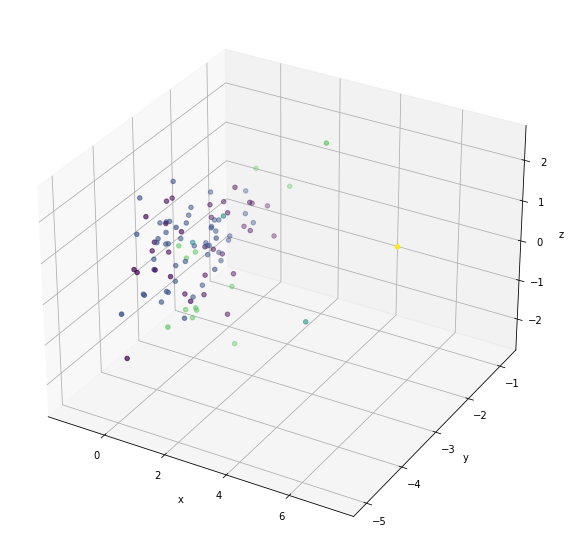

In [94]:
threedee = plt.figure(figsize=(12,10)).gca(projection='3d')
threedee.scatter(result_df2["dim[0]"], result_df2["dim[1]"], result_df2["dim[2]"], c=result_df2.prediction)
threedee.set_xlabel('x')
threedee.set_ylabel('y')
threedee.set_zlabel('z')
plt.show()

In [1]:
# suggest 2D first
# try t-sne
# describing clusters
# look at what you want to visualize
# tf-idf

In [ ]:
# Things to note
# Errors and lack of clarity in documentation basically ate up 
# 6+ hours in something that should have been much quicker
# Also I had an unforseen 20 hours per week additional committment at the 
# cost of securing a job (not that is an excuse)

In [95]:
# Future Work: Change plot library to one that can 
# move around 3D and hover labels to see what each thing is

In [ ]:
# Clustered & Visualized: Needs work and code can be reduced, 
# not sure if I should leave it for explainability

In [ ]:
# Next: After revamping the above, work on inspecting outliers on whole data
# Unsure if I will get to the most important parts of the ingredient, is that okay?

In [ ]:
# Timeline: Off by two weeks, had a buffer but will likely consume it, many
# late night coffees might need to occur